# Personality prediction from tweet

by Angelo Basile

In [1]:
import numpy as np
np.random.seed(113) #set seed before any keras import
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from keras.preprocessing import sequence
from collections import Counter
import pydot

Using TensorFlow backend.


## Dataset


In [2]:
seed=0
corpus = pd.read_csv('twistytest.csv', 
                     index_col=0, 
                     header=1, 
                     names=['user_id', 'lang', 'text', 'mbti'])
corpus.sample(5)

,user_id,lang,text,mbti
436,206814204,it,['prostituzione intellettuale (cit.futura) htt...,ENFJ
121,1520373739,it,['@nanawani_ haha grazie a Dio la lau ci fa la...,INTJ
214,883135740,it,"[""Certo, poi devo prendere ripetizioni di anal...",INFJ
885,13264792,de,['@GoldeCarlsson @theRosenblatts Ich denk die ...,INFP
104,169452362,it,"['Un ora e mezza di attesa. Bello schifo', 'Da...",INFP


In [13]:
#here we limit the corpus size. The SVM with all the text can learn somethign
corpus.text = corpus.text.apply(lambda x: x[:1000]) 
corpus.mbti = corpus.mbti.apply(lambda x: x[0])

#corpus = tmp.sample(frac=1, random_state=seed)
e = corpus[corpus.mbti.apply(lambda x: x == 'E')]
i = corpus[corpus.mbti.apply(lambda x: x == 'I')].sample(226)
corpus = pd.concat([e,i]).sample(frac=0.3, random_state=seed)
print(corpus.shape)

## set max length of doc per author
sentences = corpus.text#.apply(lambda x: x[:100000])
## trim labels: convert problem to binary classification I vs E
labels = corpus.mbti

## make sure we have a label for every data instance
assert(len(sentences)==len(labels))
data={}
np.random.seed(113) #seed
data['target']= np.random.permutation(labels)
np.random.seed(113) # use same seed!
data['data'] = np.random.permutation(sentences)

(136, 4)


In [14]:
# preview the dataset
print(corpus.shape)
corpus.head()

(136, 4)


,user_id,lang,text,mbti
610,430124293,de,['@Schmidtlepp Frage vor Wahl zum BuPräs:gesch...,E
836,621638341,de,"[""damn. i'm here again."", ""@chaospiral hey, i'...",E
527,181297248,de,['Der @eigensinn83 schwafelt meine Timeline zu...,I
170,271514739,it,"['""Tu con le fave dovevi intendertene! E poi i...",I
855,1083774439,de,['Trailer Salzburger Festspiele 2013: http://t...,I


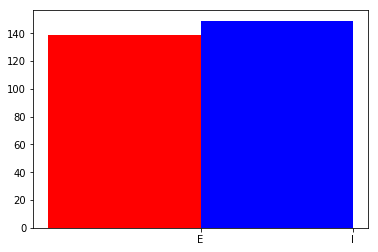

In [15]:
# plot the distribution of labels

import matplotlib.pyplot as plt

l, v = zip(*Counter(y_train).items())
indexes = np.arange(len(l))
width = 1
plt.bar(indexes, v, width, color=['r', 'b'])
plt.xticks(indexes + width * 0.5, l)
plt.show()

In [16]:
#split the data into train, dev, test

X_rest, X_test, y_rest, y_test = train_test_split(data['data'], data['target'], test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_rest, y_rest, test_size=0.2)
del X_rest, y_rest
print("#train instances: {} #dev: {} #test: {}".format(len(X_train),len(X_dev),len(X_test)))

#train instances: 86 #dev: 22 #test: 28


## Baseline

For the baseline we use an SVM with a sparse feature representation.

We use both character- and word-ngrams.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pipeline = Pipeline([('features', FeatureUnion([('wngram', TfidfVectorizer(ngram_range=(1,2))),
                                                ('cngram', TfidfVectorizer(analyzer='char'))])),
                     ('cls', LinearSVC())])
pipeline.fit(X_train, y_train)

## Results

The SVM works quite well already: we outperform the random baseline by a signficant margin.

In [12]:
testpred = pipeline.predict(X_test)
print(accuracy_score(testpred, y_test))
print(classification_report(testpred, y_test))

0.725274725275
             precision    recall  f1-score   support

          E       0.65      0.74      0.69        38
          I       0.79      0.72      0.75        53

avg / total       0.73      0.73      0.73        91



## Neural network

First we have to encode the labels in the one-hot format. Since this is a binary classification format, we don't convert them to a categorical format.

In [18]:
from keras.utils import np_utils
y2i = defaultdict(lambda: len(y2i))
y_train_num = [y2i[mbti] for mbti in y_train]
y_dev_num = [y2i[mbti] for mbti in y_dev]
y_test_num = [y2i[mbti] for mbti in y_test]
num_classes = len(np.unique(y_train_num))
print(num_classes)

2


## Text representation

For the baseline we used a one-hot encoding. For our neural model we are going to represent the text using a dense representation. We will be building it from characters.

In [19]:
from collections import defaultdict

# convert words to indices, taking care of UNKs
def get_characters(sentence, c2i):
    out = []
    for word in sentence.split(" "):
        chars = []
        for c in word:
            chars.append(c2i[c])
        out.append(chars)
    return out

c2i = defaultdict(lambda: len(c2i))

PAD = c2i["<pad>"] # index 0 is padding
UNK = c2i["<unk>"] # index 1 is for UNK
X_train_num = [get_characters(sentence, c2i) for sentence in X_train]
c2i = defaultdict(lambda: UNK, c2i) # freeze - cute trick!
X_dev_num = [get_characters(sentence, c2i) for sentence in X_dev]
X_test_num = [get_characters(sentence, c2i) for sentence in X_test]

max_sentence_length=max([len(s.split(" ")) for s in X_train] 
                        + [len(s.split(" ")) for s in X_dev] 
                        + [len(s.split(" ")) for s in X_test] )
max_word_length = max([len(word)  for sentence in X_train_num for word in sentence])

In [26]:
### we need both max sent and word length
print(max_sentence_length)
print(max_word_length)
print(X_train[0:2])
print(X_train_num[0][:100]) # example how the first two sentences are encoded

182
92
[ '[\'Herzlich Willkommen, kleiner Mats! &lt;3\', \'Nein. Selbst wenn man krank ist sollte man nicht ,,Familien im Brennpunkt" schauen. Neinneinnein.\', \'Irgendwer hat heute was dagegen, dass ich zur Uni komme. Meine Schusseligkeit kennt keine Grenzen.\', \'Geschichten aus dem Waschsalon Kapitel I: ,,als mich ein alleinerziehender 40-Jähriger fragte, ob ich mal einen Kaffee mit ihm trinken gehe"\', \'He, #SiZolli! Morgen hättest Du 90 Minuten durchspielen können, weißte selbst, ne?! #fck #effzeh #traditionsverein @Rote_Teufel_RT @fckoeln\', \'@FabianM_Mueller diese Geschichte wird mit Sicherheit kein zweites Kapitel bekommen ;)\', \'Es gibt da diese eine Person, der ich dafür danken möchte, mir die Musik von #Olson gezeigt zu haben. #thisgoesoutto #dreiTageGlück\', \',,generiert" ist übrigens ein scheiß Wort und sollte nicht im Zusammenhang mit meinen Artikeln verwendet werden.\', \'@gelsen Rheinland-Pfälzischer Rosé hilft. Gegen alles.\', \'@gelsen hatte ich die letzten drei T

In [27]:
def pad_words(tensor_words, max_word_len, pad_symbol_id, max_sent_len=None):
    """
    pad character list all to same word length
    """
    padded = []
    for words in tensor_words:
        if max_sent_len: #pad all to same sentence length (insert empty word list)
            words = [[[0]]*(max_sent_len-len(words))+ words][0] #prepending empty words
        padded.append(sequence.pad_sequences(words, maxlen=max_word_len, value=pad_symbol_id))
    return np.array(padded)

In [28]:
X_train_pad_char = pad_words(X_train_num, max_word_length, 0, max_sent_len=max_sentence_length)
X_dev_pad_char = pad_words(X_dev_num, max_word_length, 0, max_sent_len=max_sentence_length)
X_test_pad_char = pad_words(X_test_num, max_word_length, 0, max_sent_len=max_sentence_length)

In [29]:
X_train_pad_char.shape

(86, 182, 92)

In [30]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, GRU, TimeDistributed, Embedding, Bidirectional
import keras

## My model: WENP (WE Need more Power)



Instead of using a separate word embedding matrix, compose words through characters (see https://aclweb.org/anthology/W/W16/W16-4303.pdf)

In [31]:
batch_size=8
max_chars = len(c2i)
c_dim=50
c_h_dim=32
w_h_dim=32
char_vocab_size = len(c2i)

## lower-level character LSTM
input_chars = Input(shape=(max_sentence_length, max_word_length), name='main_input')

embedded_chars = TimeDistributed(Embedding(char_vocab_size, c_dim,
                                         input_length=max_word_length), name='char_embedding')(input_chars)
char_lstm = TimeDistributed(Bidirectional(GRU(c_h_dim)), name='GRU_on_char')(embedded_chars)

word_lstm_from_char = Bidirectional(GRU(w_h_dim), name='GRU_on_words')(char_lstm)

# And add a prediction node on top
predictions = Dense(1, activation='relu', name='output_layer')(word_lstm_from_char)


In [32]:
model = Model(inputs=input_chars, outputs=predictions)


model.compile(loss='binary_crossentropy', optimizer='adam',
                      metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 182, 92)           0         
_________________________________________________________________
char_embedding (TimeDistribu (None, 182, 92, 50)       20500     
_________________________________________________________________
GRU_on_char (TimeDistributed (None, 182, 64)           15936     
_________________________________________________________________
GRU_on_words (Bidirectional) (None, 64)                18624     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 55,125
Trainable params: 55,125
Non-trainable params: 0
_________________________________________________________________


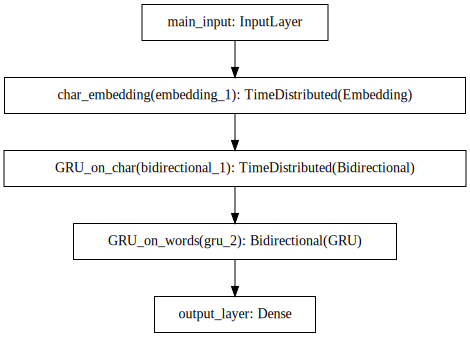

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [34]:
model.fit(X_train_pad_char, y_train_num, epochs=10, batch_size=8)

Epoch 1/10
86/86 [==============================] - 29s - loss: 0.8218 - acc: 0.5000    
Epoch 2/10
86/86 [==============================] - 31s - loss: 0.7154 - acc: 0.4651    
Epoch 3/10
86/86 [==============================] - 32s - loss: 0.6856 - acc: 0.5465    
Epoch 4/10
86/86 [==============================] - 31s - loss: 0.6935 - acc: 0.5465    
Epoch 5/10
86/86 [==============================] - 31s - loss: 0.6806 - acc: 0.5349    
Epoch 6/10
86/86 [==============================] - 31s - loss: 0.6781 - acc: 0.5465    
Epoch 7/10
86/86 [==============================] - 30s - loss: 0.6465 - acc: 0.6047    
Epoch 8/10
86/86 [==============================] - 29s - loss: 0.6210 - acc: 0.7442    
Epoch 9/10
86/86 [==============================] - 30s - loss: 0.5810 - acc: 0.7209    
Epoch 10/10
86/86 [==============================] - 32s - loss: 0.5137 - acc: 0.8140    


In [35]:
loss, accuracy = model.evaluate(X_test_pad_char, y_test_num)

28/28 [==============================] - 3s


In [36]:
print(accuracy)

0.5


## Conclusions

:(